In [1]:
# PROGRAMA PARA GRAFICAR A PARTIR DEL ARCHIVO orbitasreo.dat

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from math import *
import numpy as np
import os
import sys
# Algunas configuraciones generales:
# mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 32
mpl.rcParams['xtick.labelsize'] = 28
mpl.rcParams['ytick.labelsize'] = 28
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

In [3]:
# Kp:K resonance?
K2 = 1
K1 = 2
RESONANCIA = str(K2) + '-' + str(K1) # String "Kp-K"

# perturber eccentricity ep?
ep = 0.3
ep_text = "{0:.1g}".format(ep) # .1g implies consider 1 significative digit for ep.

# Si ANGLE = 0 => angulos: (0, 360). Si ANGLE = 1 => angulos: (-180,180).
ANGLE = 1

# DIRECTORIOS:
# Tronco comun de directorios:
COMUN = "/home/juan/Escritorio/TESIS/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/GUIADO POR 3DH" + "/e2=" + ep_text + "/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/MINIMO EW - INICIAL CORRIDO" + "/e2=" + ep_text + "/w=0/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/MINIMOS SEGUN MAPAS/R_sigma_w1" + "/e2=" + ep_text + "/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/LEY ESTRUCTURA" + "/e2=" + ep_text + "/precise/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/OTROS/1/"
dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/ep=" + ep_text + "/"# "_prueba/" 
datos_evorb = "datos.dat"
archivo_evorb = 'orbitasreo.sal'

CASES = np.array([10, 11, 12])-9  # CASOS a comparar con el mapa   ; [33, 35, 37]

COLORS = ['yellow', 'limegreen', 'blue']#, 'red']
ALFA = [1, 1, 1] 

### Gráficos:

In [4]:
# EVORB15 NUMERICAL INTEGRATION IS PROCESSED:
    
# In Din is load the data
Din = pd.read_csv(dir_evorb + archivo_evorb , delimiter=r"\s+")

# This piece of code is to find 3 parameters from datos.dat (input file for numerical integration)
string1 = 'TIEMPO MAXIMO DE LA SIMULACION'
string2 = 'INTERVALO DE ESCRITURA'
string3 = 'NUMERO DE PARTICULAS'

# opening a text file
file = open(dir_evorb + datos_evorb, "r", encoding = "ISO-8859-1")

# setting flag to 0
flag = 0

# Loop through the file line by line
for line in file:
    
    if (flag == 1):
        T_tot = int(float(line)) # Tiempo de integracion total
        flag = 0
    if (flag == 2):
        DT_esc = int(float(line)) # Intervalo de escritura
        flag = 0
    if (flag == 3):
        Npar = int(float(line)) # Nro de partículas
        flag = 0
        
    # checking string is present in line or not
    if string1 in line:
        flag = 1
    if string2 in line:
        flag = 2
    if string3 in line:
        flag = 3
        
#print(T_tot, DT_esc, Npar)
# closing datos.dat
file.close()

Npla = 1 # N° de planetas
Nobj = Npla + Npar # N° de objetos

# Number of points:
Nt = int(T_tot/DT_esc) # Total integration time / Writing interval

# The precision can be lowered to run the code faster:
FIL = 1 # FIL is the number of points that are skipped. FIL = 1 does not skip any data.
Din = Din[Din['t'] % int(FIL*DT_esc) == 0]
Nt = int(Nt/FIL)

# DEFINO LOS ÍNDICES DE LOS OBJETOS:
obj = np.insert(np.arange(10, 10 + Npar), 0 , np.arange(1, 1 + Npla)) # 10 es el indice de la primer partícula
# Inicializo matriz 3D con todos los objetos: 
D = np.empty((Nobj, Nt+1, 8)) # 8 son las columnas que hay en archivo_evorb
D[:] = np.NaN
# Recorro los Nobj índices de objetos y filtro segun columna 'N' para asignar a la matriz 3D
for i, j in zip(range(len(obj)), obj):
    N_vivo = np.count_nonzero((Din['N'].values == j)) # Esto es para considerar los casos donde la partícula es eyectada prematuramente
    D[i, 0:N_vivo, :] =  Din[Din['N'].values == j]
# Paso a dataframe el planeta:
D_pla =  pd.DataFrame(D[0,:,:], columns = ['t','a','e','i','nodo','argper','anomed','N'])

# CASE selects the particle:
D_obj=[]
for CASE in CASES:
    D_obj.append( pd.DataFrame(D[CASE,:,:], columns = ['t','a','e','i','nodo','argper','anomed','N']) )
    
# Filtro NaNs:
# D_pla = D_pla[~(np.isnan(D_obj['t'].values))]
# D_obj = D_obj[~(np.isnan(D_obj['t'].values))] 

# Planet elements:
varpi_p = D_pla['nodo'].values + D_pla['argper'].values
varpi_p = np.remainder(varpi_p, 360)
lambda_p = varpi_p + D_pla['anomed'].values
    
# Adjust angles:
if (ANGLE == 1):
    varpi_p = np.where(varpi_p>180, varpi_p - 360, varpi_p) # To change domain from (0, 360) to (-180, 180)
    lambda_p = np.where(lambda_p>180, lambda_p - 360, lambda_p)

# Number of cases
Ncas = len(CASES)

# Initialize numerical integration variables:
t          = np.empty((Ncas, Nt+1)) 
a          = np.empty((Ncas, Nt+1)) 
e          = np.empty((Ncas, Nt+1))
varpi      = np.empty((Ncas, Nt+1))
lambda_    = np.empty((Ncas, Nt+1))
sigma      = np.empty((Ncas, Nt+1))
#theta      = np.empty((Ncas, Nt+1))
DeltaVarpi = np.empty((Ncas, Nt+1))

for i in range(Ncas):

    # OBTAIN TIME
    t[i] = D_obj[i]['t'].values
    #t_single = np.sort(list(set(t))) # Remove duplicated values and the sort them up.

#     # TSPAN = Max time to show in the plots.
#     TSPAN = max(t) # By default

    # INTEGRATION VARIABLES:
    a[i] = D_obj[i]['a'].values
    e[i] = D_obj[i]['e'].values

    # VARPIs & LAMBDAs:
    varpi[i] = D_obj[i]['nodo'].values + D_obj[i]['argper'].values
    varpi[i] = np.remainder(varpi[i], 360)
    lambda_[i] = varpi[i] + D_obj[i]['anomed'].values

    # SIGMA & THETA DEFINITIONS:
#     if (THETA):
#         sigma[i] = (K1*lambda_[i] - K2*lambda_p + (K2-K1)*varpi_p)
#     else:
    sigma[i] = (K1*lambda_[i] - K2*lambda_p + (K2-K1)*varpi[i])
    sigma[i] = np.remainder(sigma[i], 360)
#    theta[i] = (K1*lambda_[i] - K2*lambda_p + (K2-K1)*varpi_p)
#    theta[i] = np.remainder(theta[i], 360)

    # Adjust angles:
    if (ANGLE == 1):
        varpi[i] = np.where(varpi[i]>180, varpi[i] - 360, varpi[i]) # To change domain from (0, 360) to (-180, 180)
        sigma[i] = np.where(sigma[i]>180, sigma[i] - 360, sigma[i]) 
#        theta[i] = np.where(theta[i]>180, theta[i] - 360, theta[i])
        lambda_[i] = np.where(lambda_[i]>180, lambda_[i] - 360, lambda_[i])  

    # DEF. DELTA VARPI:    
    DeltaVarpi[i] = varpi[i] - varpi_p
    DeltaVarpi[i] = np.remainder(DeltaVarpi[i], 360)
    if (ANGLE == 1):
        DeltaVarpi[i] = np.where(DeltaVarpi[i]>180, DeltaVarpi[i] - 360, DeltaVarpi[i]) # To change domain from (0, 360) to (-180, 180)
    
# Filtro Dobj segun algun criterio (old):
# D_pla = D_pla[(D_obj['argper'].values >= 179) & (D_obj['argper'].values <= 181)]
# D_obj = D_obj[(D_obj['argper'].values >= 179) & (D_obj['argper'].values <= 181)]
# D_pla = D_pla[(D_obj['t'].values <= 130000)]
# D_obj = D_obj[(D_obj['t'].values <= 130000)]

In [5]:
TSPAN = [t.min(), t.max()]
#TSPAN = [t.min(), 1e4]

Amax = a.max()
Amin = a.min()
DeltaA = Amax - Amin
# print(np.mean(a[2]))
# Amin = 3.966
# Amax = 3.97
# DeltaA = Amax - Amin
# TSPAN = [1.4e6, 1.8e6]   #   [1.4e6, 1.8e6]

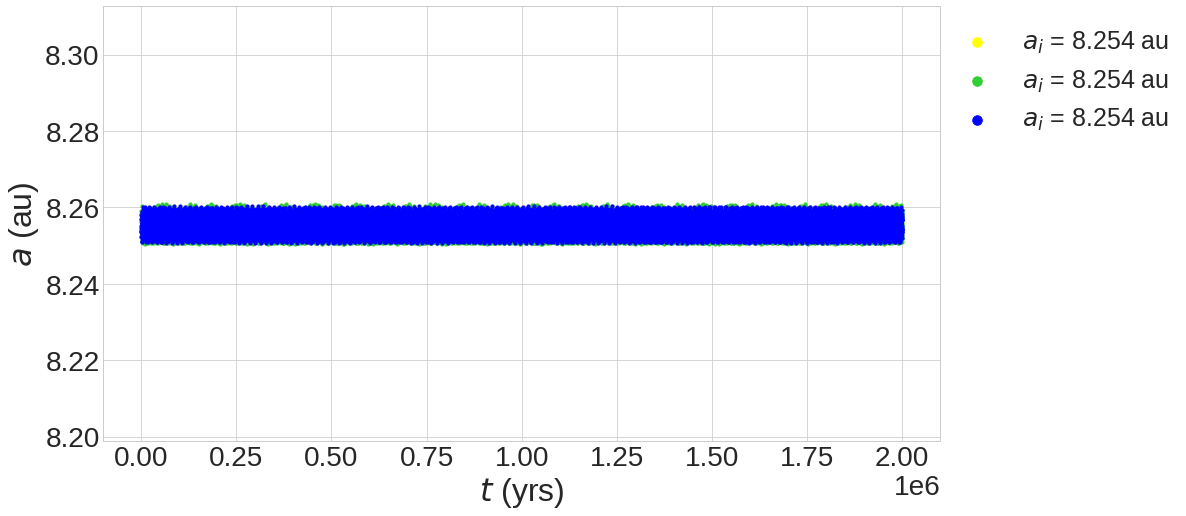

In [6]:
fig = plt.figure(figsize=(15,8))
# Grafico:
for i in range(Ncas):
    a_inic = a[i][0]
    plt.scatter(t[i], a[i], s = 10, c = COLORS[i], label = '$a_i$ = %1.3f au' % a_inic, alpha = ALFA[i])
            
leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.3, 1), markerscale = 3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.xlabel('$t$ (yrs)')#, fontsize=18)
plt.ylabel('$a$ (au)') #, fontsize=18)
plt.ylim([Amin - 5*DeltaA, Amax + 5*DeltaA])
# plt.xlim(TSPAN)

plt.show();

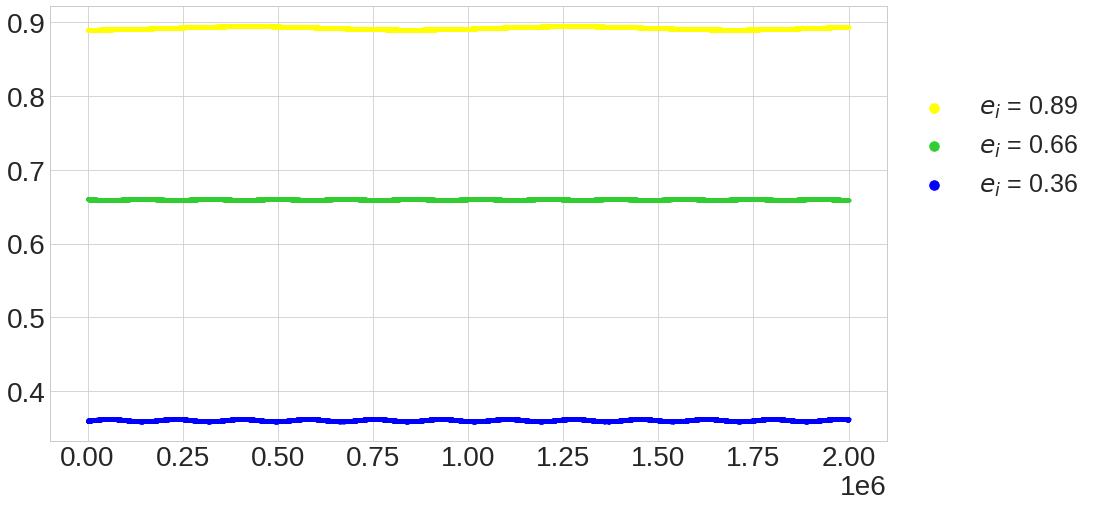

In [7]:
fig = plt.figure(figsize=(15,8))
# Grafico:
for i in range(Ncas):
    e_inic = e[i][0]
    plt.scatter(t[i], e[i], s = 10, c = COLORS[i], label = '$e_i$ = %1.2f' % e_inic, alpha = ALFA[i])
    
leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.0, 0.85), markerscale = 3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# plt.xlabel('t (yrs)')
# plt.ylabel('$e$')
# plt.ylim([0,1])
# plt.xlim(TSPAN)

plt.show();

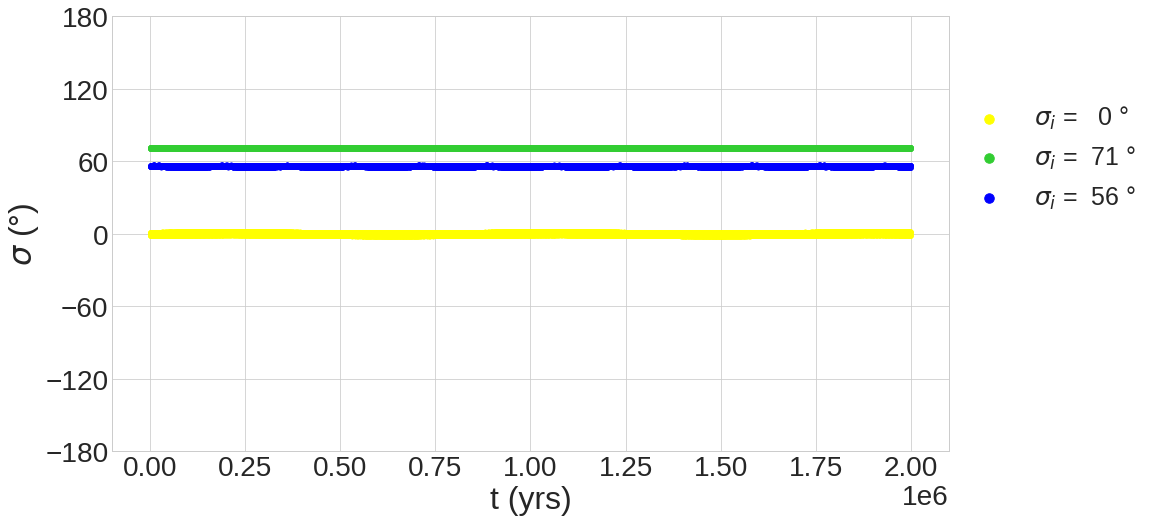

In [8]:
# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 8))

#TAM = [10, 10, 10, 2] 

# Grafico:
for i in range(Ncas):
    sigma_inic = sigma[i][0]
    plt.scatter(t[i], sigma[i], s = 10, c = COLORS[i], label =  r'$\sigma_i$ = %3.0f °' % sigma_inic, alpha = ALFA[i])
    
leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.25, 0.85), markerscale = 3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('t (yrs)')
plt.ylabel('$\sigma$ (°)')
if (ANGLE == 0):
    plt.ylim([0,360])
    plt.yticks(np.arange(0,420,60))
else:
    plt.ylim([-180,180])
    plt.yticks(np.arange(-180,240,60))
# plt.xlim(TSPAN)    

# plt.grid(lw = 0.5, c='k', ls=':') 

plt.show();

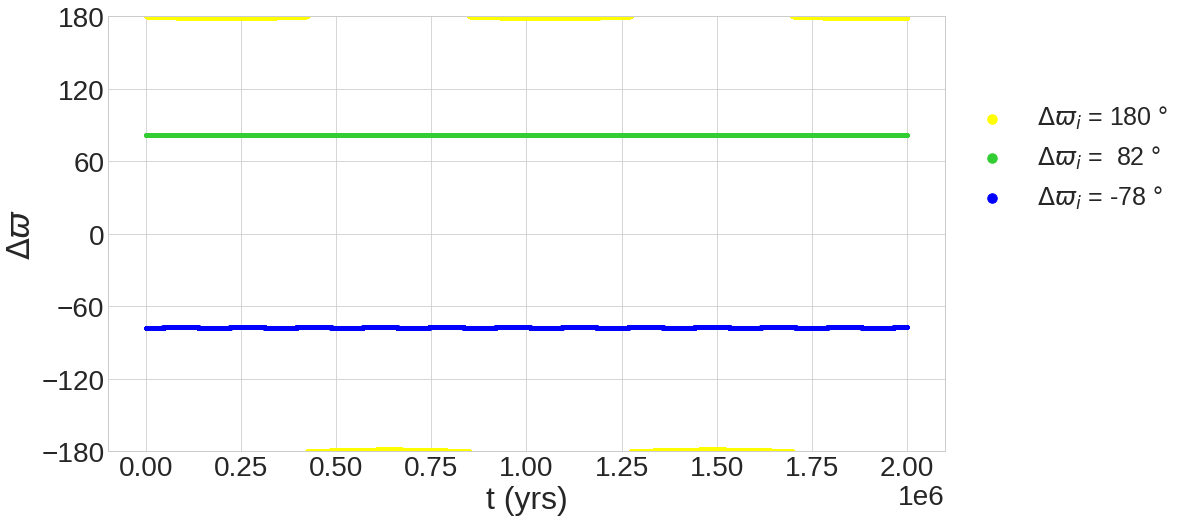

In [9]:
plt.figure(figsize=(15,8))
# Grafico:
for i in range(Ncas):
    DeltaVarpi_inic = DeltaVarpi[i][0]
    plt.scatter(t[i], DeltaVarpi[i], s = 10, c = COLORS[i], label = r'$\Delta\varpi_i$ = %3.0f °' % DeltaVarpi_inic, alpha = ALFA[i])
    
    
leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.0, 0.85), markerscale = 3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('t (yrs)')
plt.ylabel(r'$\Delta \varpi$')
if (ANGLE == 0):
    plt.ylim([0,360])
    plt.yticks(np.arange(0,420,60))
else:
    plt.ylim([-180,180])
    plt.yticks(np.arange(-180,240,60))
# plt.xlim(TSPAN)

plt.show();

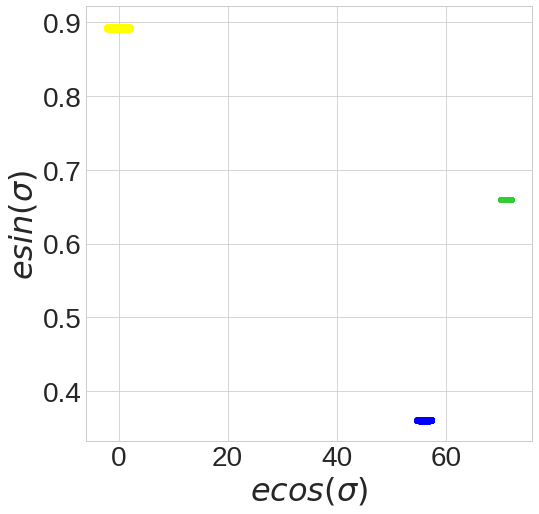

In [10]:
X = np.empty((Ncas, Nt+1)) 
Y = np.empty((Ncas, Nt+1))
plt.figure(figsize=(8,8))
# Grafico:
for i in range(Ncas):
    X[i] = e[i]*np.cos(sigma[i]*pi/180) 
    Y[i] = e[i]*np.sin(sigma[i]*pi/180)
    plt.scatter(sigma[i], e[i], s = 10, c = COLORS[i])#, label = r'$\Delta\varpi_i$ = %3.0f °' % DeltaVarpi_inic)#, alpha = ALFA[i])
    
    
# leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.0, 0.85), markerscale = 3)
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.xlabel(r'$e cos(\sigma)$')
plt.ylabel(r'$e sin(\sigma)$')

# plt.xlim([-1,1])
# plt.xticks(np.arange(-1,1.5,0.5))
# plt.ylim([-1,1])
# plt.yticks(np.arange(-1,1.5,0.5))

plt.show();

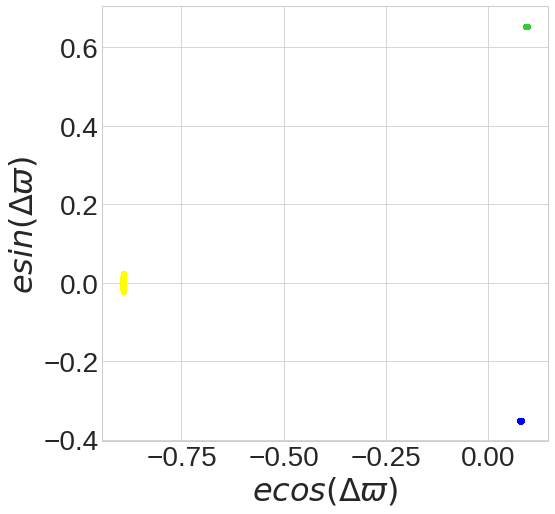

In [11]:
K = np.empty((Ncas, Nt+1)) 
H = np.empty((Ncas, Nt+1))
plt.figure(figsize=(8,8))
# Grafico:
for i in range(Ncas):
    K[i] = e[i]*np.cos(DeltaVarpi[i]*pi/180) 
    H[i] = e[i]*np.sin(DeltaVarpi[i]*pi/180)
    plt.scatter(K[i], H[i], s = 10, c = COLORS[i])#, label = r'$\Delta\varpi_i$ = %3.0f °' % DeltaVarpi_inic)#, alpha = ALFA[i])
    
    
# leg = plt.legend(prop={'size': 25}, bbox_to_anchor=(1.0, 0.85), markerscale = 3)
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.xlabel(r'$e cos(\Delta\varpi)$')
plt.ylabel(r'$e sin(\Delta\varpi)$')

# plt.xlim([-1,1])
# plt.xticks(np.arange(-1,1.5,0.5))
# plt.ylim([-1,1])
# plt.yticks(np.arange(-1,1.5,0.5))

plt.show();

## FIN DEL PROGRAMA